In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

import pandas as pd
import json
from io import StringIO
import os


raw_df = pd.read_csv("Big_Table.csv")

# Finding features of interest
In order to do clusterin, we first need to select the features that can be used to cluster data. There are several aspects to be considered when choosing such features. We arrange them by numiercal orders to tackle step by step.

1. No missing value: Although some clustering algorithm can tolerate missing values, we still choose to dispose features with missing values to expand our options for algorithms. Also missing values are aggregated in just a few columns in a certain leagues' data. Removing them will not loose too much information, and not removing them will cause observations from these leagues to be the only ones with missing data, thereby further skewing the result.

2. No Extreme Outliers unexplained: Although we tolerate the outliers in our dataset, we must find them and explain their origins, to ensure these are natrually occuring, as opposed to being introduced by human mistakes when collecting and cleaning the data. This step also prevents the downstream analysis from being affected by the human introduced outliers.

3. No High Correlation: Although there are always going to be correlations amoung features, we want to avoid highly correlated or even identical features, because that will inflate the total dimension of the dataset, and hence lowering the validity of our measurements.

## Removing Missing Data

In [ ]:
Rks = raw_df['Rk']
df = raw_df.dropna(axis=1)

f"There are {raw_df.shape[1]} columns in raw data, {df.shape[1]} after filtering out the columns with null"

'There are 95 columns in raw data, 85 after filtering out the columns with null'

In [ ]:
df

,Squad,Unnamed: 1_level_0 # Pl_x,Unnamed: 2_level_0 90s_x,Standard Gls,Standard Sh,Standard SoT,Standard SoT%,Standard Sh/90,Standard SoT/90,Standard G/Sh,...,Tackles Att 3rd,Challenges Tkl,Challenges Att,Challenges Tkl%,Challenges Lost,Blocks Blocks,Blocks Sh,Blocks Pass,League,Season
0,Atlanta Utd,22,7.0,12,106,38,35.8,15.14,5.43,0.09,...,18,72,133,54.1,61,89,31,58,Major-League-Soccer,2018-2019
1,Austin,19,8.0,11,61,16,26.2,7.62,2.00,0.16,...,18,53,121,43.8,68,82,31,51,Major-League-Soccer,2018-2019
2,CF Montréal,24,7.0,10,68,24,35.3,9.71,3.43,0.12,...,7,56,97,57.7,41,112,39,73,Major-League-Soccer,2018-2019
3,Charlotte,21,8.0,9,78,30,38.5,9.75,3.75,0.10,...,30,67,122,54.9,55,87,20,67,Major-League-Soccer,2018-2019
4,Chicago Fire,22,8.0,11,82,28,34.1,10.25,3.50,0.10,...,12,74,149,49.7,75,102,31,71,Major-League-Soccer,2018-2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1556,vs Sarmiento,32,27.0,26,440,121,27.5,16.30,4.48,0.05,...,42,144,359,40.1,215,250,66,184,Primera-Division,2020-2021
1557,vs Talleres,31,27.0,21,302,99,32.8,11.19,3.67,0.06,...,33,262,596,44.0,334,282,79,203,Primera-Division,2020-2021
1558,vs Tigre,27,27.0,29,326,111,34.0,12.07,4.11,0.09,...,42,272,575,47.3,303,321,81,240,Primera-Division,2020-2021
1559,vs Tucumán,26,27.0,26,371,106,28.6,13.74,3.93,0.06,...,60,219,477,45.9,258,307,77,230,Primera-Division,2020-2021


Removing the rows that has 'vs ' as the start of Squad, because it records statistics of teams against a team, not statistics of a team

In [ ]:
df = df[~df['Squad'].str.startswith('vs ')]

Additionally, we also want to remove columns that are not numerical, because it would hinder our clustering. If there are categorical data that are very important, then we will transform them into numerical values. However, we would like to make an exception for the "Squad" variable, because it is easier for us to understand the data if we can call each observation by its team name.

In [ ]:
sqd = df["Squad"]
df = df.select_dtypes(include=[np.number])
print(f"There are {df.shape[1]} columns remainig after removing categorical data")

There are 82 columns remainig after removing categorical data


## Inspecting extremes

In [ ]:
from sklearn.preprocessing import StandardScaler
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the data
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

print("Standardized Data:")
df_scaled.insert(loc=0, column='Squad', value=sqd)
df_scaled

Standardized Data:


,Squad,Unnamed: 1_level_0 # Pl_x,Unnamed: 2_level_0 90s_x,Standard Gls,Standard Sh,Standard SoT,Standard SoT%,Standard Sh/90,Standard SoT/90,Standard G/Sh,...,Tackles Def 3rd,Tackles Mid 3rd,Tackles Att 3rd,Challenges Tkl,Challenges Att,Challenges Tkl%,Challenges Lost,Blocks Blocks,Blocks Sh,Blocks Pass
0,Atlanta Utd,-1.177963,-1.951412,-1.414846,-1.709785,-1.584249,0.687226,1.312515,1.456742,-0.191639,...,-1.763258,-1.796989,-1.516852,-1.578085,-1.737724,1.561883,-1.793825,-1.788864,-1.446284,-1.836678
1,Austin,-1.769753,-1.872305,-1.464474,-1.985900,-1.981824,-1.456179,-2.083961,-2.108880,2.447327,...,-1.782554,-2.001023,-1.516852,-1.786733,-1.797648,-0.265552,-1.732356,-1.841306,-1.446284,-1.909962
2,CF Montréal,-0.783436,-1.951412,-1.514102,-1.942949,-1.837251,0.575590,-1.139993,-0.622338,0.939346,...,-1.821147,-1.905007,-1.938977,-1.753788,-1.917497,2.200598,-1.969449,-1.616554,-1.263614,-1.679642
3,Charlotte,-1.375226,-1.872305,-1.563730,-1.881590,-1.728822,1.290059,-1.121927,-0.289685,0.185356,...,-1.898333,-1.784987,-1.056352,-1.632993,-1.792654,1.703820,-1.846512,-1.803847,-1.697456,-1.742457
4,Chicago Fire,-1.177963,-1.872305,-1.464474,-1.857046,-1.764965,0.307665,-0.896098,-0.549570,0.185356,...,-1.734313,-1.676969,-1.747102,-1.556123,-1.657825,0.781231,-1.670887,-1.691471,-1.446284,-1.700580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,RKC Waalwijk,-0.191647,0.184473,0.868042,0.585041,0.421695,-0.384476,0.851822,0.365225,0.562351,...,0.822463,0.543398,-0.212102,0.387591,0.249764,0.355421,0.129267,0.136516,0.334753,0.037289
1436,Sparta R'dam,-0.388910,0.184473,1.413949,0.885700,1.144558,0.664899,1.502211,1.591882,0.939346,...,0.918945,0.735430,0.171648,0.354647,0.184846,0.461873,0.041455,0.061599,-0.281760,0.215263
1437,Twente,-0.783436,0.184473,0.322134,0.192343,0.060264,-0.384476,0.002704,-0.248103,0.185356,...,0.793519,0.567402,-0.403977,0.354647,0.124922,0.657036,-0.063920,0.376252,0.951266,0.089634
1438,Utrecht,0.005617,0.184473,0.818414,-0.163539,0.168693,1.111442,-0.769633,-0.060986,1.693337,...,0.465479,0.351366,-0.403977,-0.172462,-0.059845,-0.478457,0.032674,0.376252,0.174917,0.445583


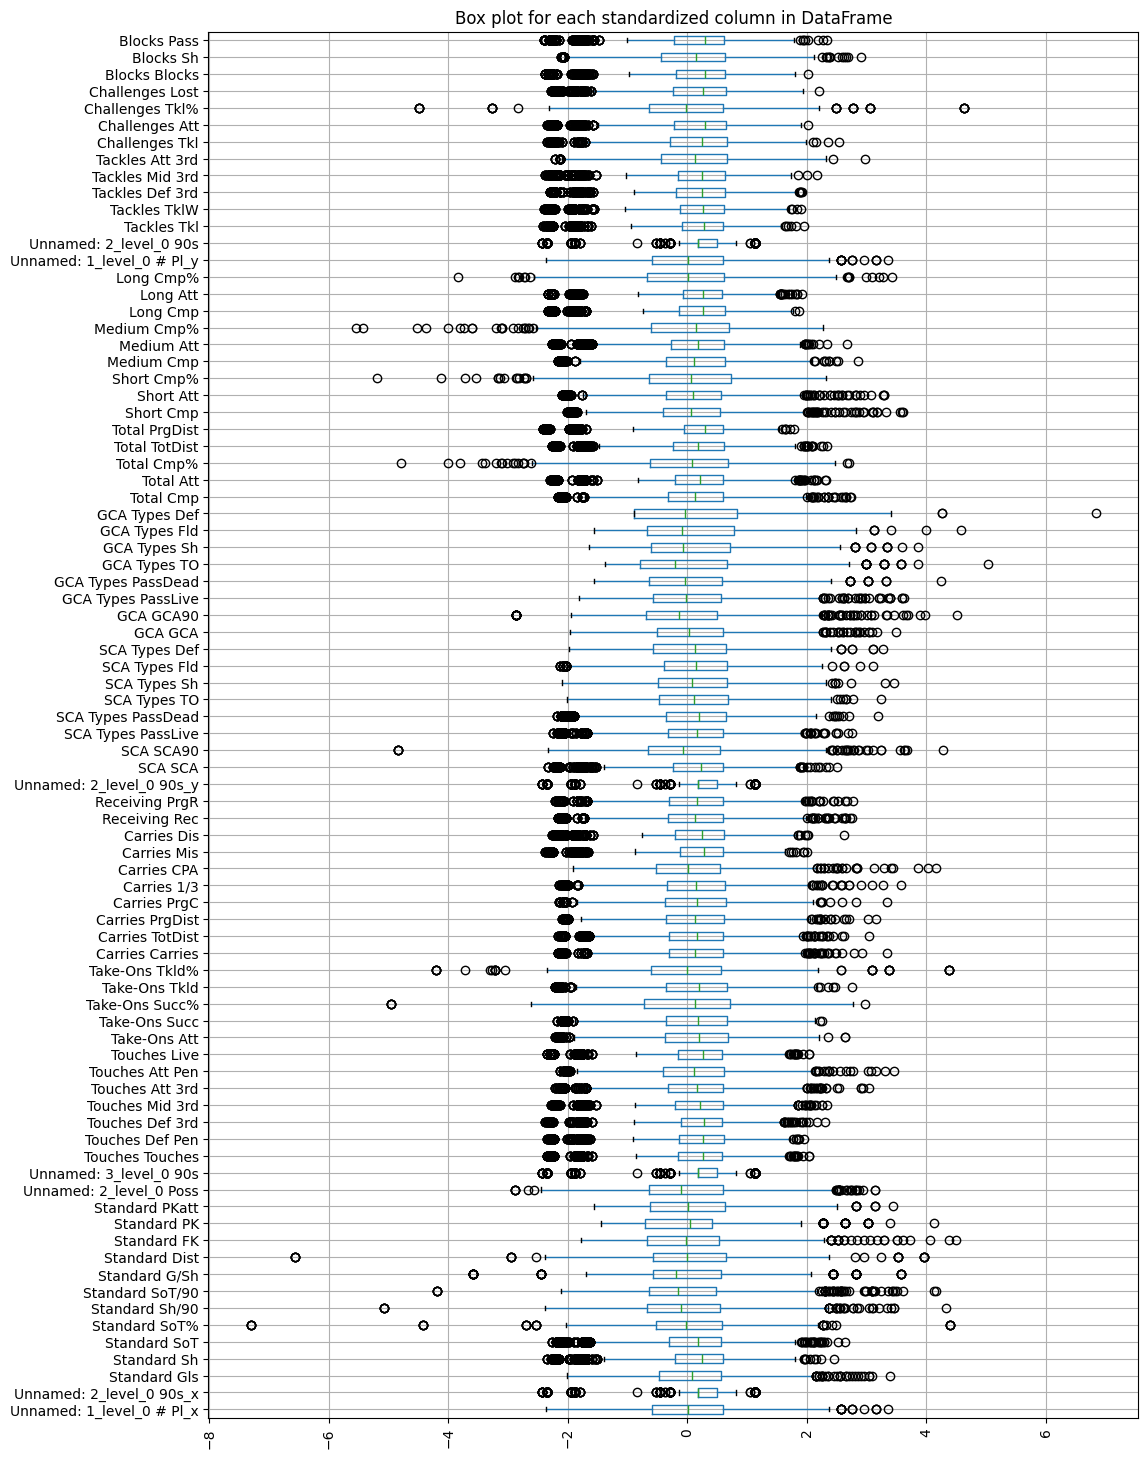

In [ ]:
# Create a box plot for the standardized data
plt.figure(figsize=(12,18))
df_scaled.boxplot(vert = False)
plt.title("Box plot for each standardized column in DataFrame")
plt.xticks(rotation=90)  # Rotates labels to prevent overlap
plt.show()

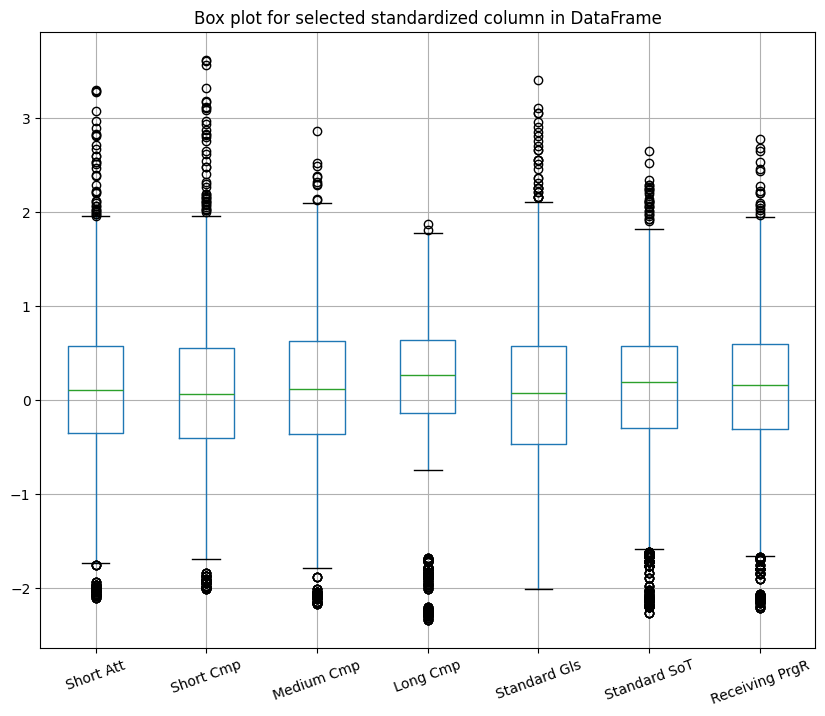

In [ ]:
df_final = df_scaled[["Short Att","Short Cmp", "Medium Cmp", "Long Cmp", "Standard Gls", "Standard SoT", 'Receiving PrgR']]
plt.figure(figsize=(10,8))
df_final.boxplot()
plt.title("Box plot for selected standardized column in DataFrame")
plt.xticks(rotation= 20)  # Rotates labels to prevent overlap
plt.show()

## Examining feature correlations

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2)  # Adjust the number of clusters as needed
clusters = kmeans.fit_predict(df_scaled.drop("Squad",axis=1))

# Add cluster labels to the DataFrame
df_scaled['Cluster'] = clusters

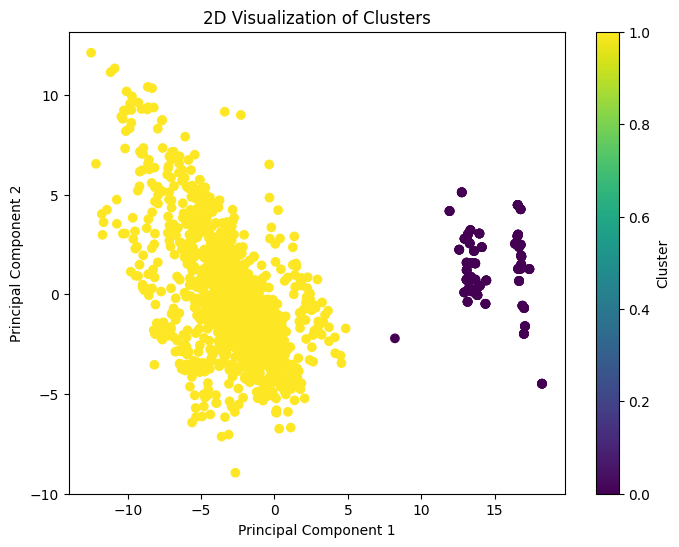

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Apply PCA to reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_scaled.drop(['Cluster','Squad'], axis=1))

# Plotting the results
plt.figure(figsize=(8, 6))
plt.scatter(principal_components[:, 0], principal_components[:, 1], c=df_scaled['Cluster'], cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D Visualization of Clusters')
plt.colorbar(label='Cluster')
plt.show()

In [ ]:
pca = PCA(n_components=2)  # Assuming you want to reduce to 2 components for visualization
pca.fit(df_final)
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=df_final.columns)
loadings

,PC1,PC2
Short Att,0.384623,0.408068
Short Cmp,0.379808,0.517750
Medium Cmp,0.384489,0.067748
Long Cmp,0.357523,-0.718021
Standard Gls,0.368406,-0.086914
Standard SoT,0.381028,-0.187694
Receiving PrgR,0.388910,-0.049887
